In [1]:
!nvidia-smi

Sun Nov  5 12:11:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet

In [3]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [4]:
# Define the transformations for the dataset
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

# Load the training and test dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
valid_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [5]:
!pip install efficientnet_pytorch

In [6]:
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNetB6
model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=10)
model.to(device)

Loaded pretrained weights for efficientnet-b6


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        56, 14, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        14, 56, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        56, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [7]:
model._dropout = nn.Dropout(p=0.5)

In [8]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [10]:
model_name = "torch-efficientnet-b6-SGD-v1"
# Training loop
num_epochs = 5
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = correct / total

    # Store loss and accuracy values
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(valid_accuracy)

    # Print the training/validation statistics
    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_accuracy:.4f}")

    # Update the learning rate
    scheduler.step()

# Save the trained model
torch.save(model.state_dict(), model_name+".pth")

Epoch: 1/5 | Train Loss: 0.5765 | Train Acc: 0.8239 | Valid Loss: 0.1141 | Valid Acc: 0.9754
Epoch: 2/5 | Train Loss: 0.1670 | Train Acc: 0.9535 | Valid Loss: 0.0559 | Valid Acc: 0.9870
Epoch: 3/5 | Train Loss: 0.1080 | Train Acc: 0.9705 | Valid Loss: 0.0422 | Valid Acc: 0.9888
Epoch: 4/5 | Train Loss: 0.0801 | Train Acc: 0.9783 | Valid Loss: 0.0354 | Valid Acc: 0.9911
Epoch: 5/5 | Train Loss: 0.0602 | Train Acc: 0.9835 | Valid Loss: 0.0278 | Valid Acc: 0.9925


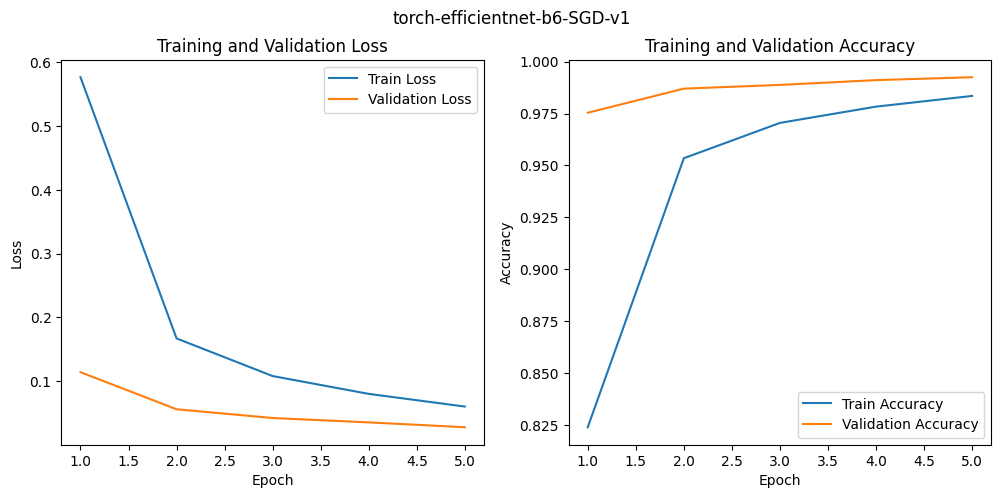

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Plot training and validation accuracy
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.suptitle(model_name)
plt.show()